<a href="https://colab.research.google.com/github/HWaymentSteele/colab_exercises/blob/main/proteinMPNN_AF2_onestopshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ProteinMPNN & AF2 one-stop shop

by Hannah W-S, thanks very much to example notebooks in [ProteinMPNN](https://github.com/dauparas/ProteinMPNN/blob/main/colab_notebooks/quickdemo.ipynb) and [ColabDesign](https://github.com/sokrypton/ColabDesign)

Last updated Nov 6, 2024

Tips:
  - make sure you're on a GPU to go fastest (check in upper right corner, change at Runtime > Change Runtime Type)
  - Will automatically download a zip including CSV with all the metrics, a zip structure models (in PDB form), and MSA for WT protein.
  But you can see/download other data using file tab on left-hand side

  Run cells one at a time, or set your options, and then go to Runtime > Run all


In [76]:
%%time
#@title Setup Code and Functions
import json, time, os, sys, glob
from datetime import datetime


if not os.path.isdir("ProteinMPNN"):
  os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN')

import os, time, gc
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@gamma")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.shared.protein import _np_rmsd
from colabdesign.shared.parsers import aa2num
from copy import copy, deepcopy

from api import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def one_hot(x,cat=None):
  if cat is None: cat = np.max(x)+1
  oh = np.concatenate((np.eye(cat),np.zeros([1,cat])))
  return oh[x]

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

#Helper functions
def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict

CPU times: user 125 µs, sys: 0 ns, total: 125 µs
Wall time: 118 µs


In [77]:
#@title Setup ProteinMPNN Inputs
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN

run_name='2QKE_test' #@param {type:"string"}

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "v_48_020" #@param ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]


backbone_noise=0.00               # Standard deviation of Gaussian noise to add to backbone atoms

path_to_model_weights='/content/ProteinMPNN/vanilla_model_weights'
hidden_dim = 128
num_layers = 3
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
mpnn_model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
mpnn_model.to(device)
mpnn_model.load_state_dict(checkpoint['model_state_dict'])
mpnn_model.eval()
print("Model loaded")

import re
from google.colab import files
import numpy as np

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

pdb='2QKE' #@param {type:"string"}
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = False #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

residues_to_fix = "1 2 3 96" #@param {type:"string"}
atomsel = [int(x) for x in residues_to_fix.split()]
#@markdown - Define which residues to keep fixed. Must be list of integers separated by spaces (i.e. `1 2 3 96`)

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed.
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ### Design Options
num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly. "many" will do 0.1, 0.2, 0.3, 0.5.
sampling_temp = "many" #@param ["many", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]

save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)

batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length

out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
#pssm_folder='ProteinMPNN/inputs/PSSM_inputs'
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.

pssm_multi=0.0                  # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=1                   # 0 for False, 1 for True

pssm_dict=None
##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
if sampling_temp=='many':
  temperatures = [0.1,0.2,0.3,0.5]
else:
  temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None


omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))

###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

fixed_positions_dict = {}
fixed_positions_dict[pdb_dict_list[0]['name']] = {x: atomsel for x in designed_chain_list}

print(chain_id_dict)
u_lengths=[]
wt_seqs=[]

for chain in chain_list:
  wt_seq = pdb_dict_list[0][f"seq_chain_{chain}"]
  print(f"Chain {chain}: length {len(wt_seq)}")
  print(wt_seq)
  wt_seqs.append(wt_seq)
  u_lengths.append(len(wt_seq))

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

print('Fixed positions:', fixed_positions_dict)


Number of edges: 48
Training noise level: 0.2A
Model loaded
{'2QKE': (['A'], [])}
Chain A: length 98
MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIG
Fixed positions: {'2QKE': {'A': [1, 2, 3, 96]}}


In [78]:
#@title Set AF2 options

model_type = "auto" #@param ["monomer (ptm)", "multimer (v3)", "auto"]
model = "all" #@param ["1", "2", "3", "4", "5", "all"]
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
recycle_early_stop_tolerance = 0.0 #@param ["0.0", "0.5", "1.0"] {type:"raw"}
use_initial_guess = False
#@markdown MSA options
use_WT_msa = True #@param {type:"boolean"}
#@markdown - If True, generate MSA once using sequence provided in starting structure, and reuse for all designs.

num_msa = 512 #@param ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
num_extra_msa = 1 #@param ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
#@markdown Stochastic options
use_dropout = False #@param {type:"boolean"}
num_seeds = 1 #@param ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}

seeds = range(num_seeds)
batches = [None]
copies=1
use_templates=False
use_mlm=False

if model_type == "monomer (ptm)":
  use_multimer = False
elif model_type == "multimer (v3)":
  use_multimer = True
elif homomer or copies > 1:
  use_multimer = True
else:
  use_multimer = False

model_opts = {"num_msa":num_msa, # number of sequences to use
              "num_extra_msa":num_extra_msa,
              "num_templates":len(batches),
              "use_mlm":use_mlm,
              "use_cluster_profile":False,
              "use_multimer":use_multimer,
              "use_templates":use_templates,
              "use_batch_as_template":False,
              "use_dgram":True,
              "protocol":"hallucination",
              "best_metric":"pae",
              "optimize_seq":False,
              "debug":False,
              "clear_prev":False}

if "af" in dir():
  if model_opts != model_opts_:
    if model_opts["use_multimer"] == af._args["use_multimer"] \
    or model_opts["use_templates"] == af._args["use_templates"]:
      old_params = dict(zip(af._model_names,
                            af._model_params))
    else:
      print("loading alphafold params")
      old_params = {}
    af = mk_af_model(old_params=old_params,
                     **model_opts)
    model_opts_ = predict.copy_dict(model_opts)
else:
  print("loading alphafold params")
  af = mk_af_model(**model_opts)
  model_opts_ = predict.copy_dict(model_opts)

run_opts = {"seed":seeds[0],
            "use_mlm":use_mlm,
            "use_dropout":use_dropout,
            "num_recycles":num_recycles,
            "model":model,
            "use_initial_guess":use_initial_guess}

af.prep_inputs(u_lengths, copies=copies, seed=seeds[0])

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

pdb_path = f"{run_name}/pdb"
os.makedirs(pdb_path, exist_ok=True)

In [79]:
#@title Run ProteinMPNN

outputs=[]
ctr=0
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()

    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = mpnn_model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"]
            else:
                sample_dict = mpnn_model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = mpnn_model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.format(name_, native_score_print, print_visible_chains, print_masked_chains, model_name, native_seq)

                    outputs.append({'design': 'WT', 'sequence': native_seq, 'MPNN_temp':0, 'MPNN_score': float(native_score_print), 'MPNN_seq_recovery': 1})

                    print(line.rstrip())
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                name = f'{run_name}_{ctr}'
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.format(temp,ctr,score_print,seq_rec_print,seq)
                outputs.append({'design': name, 'sequence': seq, 'MPNN_temp':temp, 'MPNN_score': float(score_print), 'MPNN_seq_recovery': float(seq_rec_print)})
                ctr+=1
                print(line.rstrip())

all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)

Generating sequences...
>2QKE, score=1.7574, fixed_chains=[], designed_chains=['A'], model_name=v_48_020
MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIG
>T=0.1, sample=0, score=0.9852, seq_recovery=0.3511
MAPGGPVRLLVLYLKGMTEEARRVLEELSRILEERYRGRYRLEVRDLEENPELAPDERIEPVDELAASLPPELRELVTRLKEEHGVLVGMRLLELEEE
>T=0.2, sample=1, score=1.0642, seq_recovery=0.3936
MAPGGPVHLLILYLKGETEEAKKLLEELKEIIEKEFPGKYRLKVIDLDKNPELKEDERIKPVEEVAESLPEEIREIVTKLKEETGVLVGMDLKLEEEL
>T=0.3, sample=2, score=1.0876, seq_recovery=0.3830
MAPEGKRKLLILYIKGETEKAKEVLKELKKILEEKYKGEYVLDVKDLEKNPELKEDEEIIPVEEIMKSLPPEIQELVTRLKNEEGVLIGMNLKEIEKR
>T=0.5, sample=3, score=1.4466, seq_recovery=0.3404
MAPSGRVTELVLYVIGSSPEAKELLARLADILEKRYRGKYRLRVVNLIDNPSLPEGEIIEEVEGLSETLPSELREEVLLLKRETGVLIGMDLRLGEQV


In [13]:
#@title Plot amino acid probabilties
import plotly.express as px
fig = px.imshow(np.exp(all_log_probs_concat).mean(0).T,
                labels=dict(x="positions", y="amino acids", color="probability"),
                y=list(alphabet),
                template="simple_white"
               )

fig.update_xaxes(side="top")

#pssm_mpnn = np.exp(all_log_probs_concat).mean(0).T
fig.show()

In [80]:
#@title Run AF2

if model == "all":
  models = af._model_names
else:
  models = [af._model_names[int(model) - 1]]

msa=None

if use_WT_msa:
  print('Getting WT MSA...')
  wt_msa, wt_dtx = predict.get_msa(wt_seqs, name, max_msa=4096,
          do_not_filter=True,mode='unpaired_paired',
          output_a3m=f'{run_name}_WT.a3m',
          mmseqs2_fn=run_mmseqs2,
          hhfilter_fn=run_hhfilter)

for row in outputs:
  name = row['design']
  seq = row['sequence']

  if use_WT_msa:
    # swap out first sequence for the one we designed
    msa = copy.copy(wt_msa)
    msa[0] = aa2num(seq.replace(':','')) # updates the first sequence to be the one we want.

    af.set_msa(msa, wt_dtx)
  else:
    # If not use_WT_MSA: get new MSA based on design
    msa, dtx = predict.get_msa(seq, name, max_msa=4096,
            do_not_filter=True,mode='unpaired_paired',
            mmseqs2_fn=run_mmseqs2,
            hhfilter_fn=run_hhfilter)

    af.set_msa(msa, dtx)

  tmp={}
  for seed in seeds:
    af.set_seed(seed)
    for mdl in models:
      recycle=0
      af._inputs.pop("prev",None)
      stop_recycle = False
      while recycle < num_recycles + 1:
        af.predict(dropout=use_dropout, models=[mdl], verbose=False)

        print_str = f"{name} seed={seed} model={mdl} recycle={recycle}"
        print_key = ["plddt","ptm"]
        if len(af._lengths) > 1: print_key.append("i_ptm")
        for k in print_key:
          print_str += f" {k}={af.aux['log'][k]:.3f}"

        af._inputs["prev"] = af.aux["prev"]
        af._save_results(save_best=True, verbose=False)
        af._k += 1


        recycle += 1
        if recycle > 1:
          rmsd_tol = _np_rmsd(af._tmp["traj"]["xyz"][-2],
                              af._tmp["traj"]["xyz"][-1],
                              use_jax=False)
          if rmsd_tol < recycle_early_stop_tolerance:
            stop_recycle = True
          print_str += f" rmsd_tol={rmsd_tol:.3f}"
        if stop_recycle: break

      print(print_str)
      output_pdb = f"{pdb_path}/{name}_{model}_seed{seed}.pdb"
      af.save_current_pdb(output_pdb)

      for k in print_key:
        print_mdl = mdl.split('_')[1]
        tmp.update({f'af_seed{seed}_mdl{print_mdl}_{k}': af.aux['log'][k]})

  row.update(tmp)

def get_max_median(r, typ='plddt'):
  cols = [x for x in r.index if typ in x]
  return np.max(r[cols]), np.median(r[cols])

import pandas as pd
final_outputs = pd.DataFrame.from_records(outputs)

final_outputs[['max_plddt', 'median_plddt']] = final_outputs.apply(get_max_median, axis=1, typ='plddt', result_type='expand')
final_outputs[['max_ptm', 'median_ptm']] = final_outputs.apply(get_max_median, axis=1, typ='ptm', result_type='expand')
final_outputs.to_csv(f'{run_name}_results.csv')

from google.colab import files

os.system(f'zip -r {run_name}.zip {run_name}*')
files.download(f'{run_name}.zip')

################
print("GC",gc.collect())

Getting WT MSA...
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


parsing msas
WT seed=0 model=model_1_ptm recycle=0 plddt=0.783 ptm=0.674
WT seed=0 model=model_2_ptm recycle=0 plddt=0.650 ptm=0.442
WT seed=0 model=model_3_ptm recycle=0 plddt=0.809 ptm=0.701
WT seed=0 model=model_4_ptm recycle=0 plddt=0.778 ptm=0.658
WT seed=0 model=model_5_ptm recycle=0 plddt=0.792 ptm=0.677
WT seed=1 model=model_1_ptm recycle=0 plddt=0.731 ptm=0.610
WT seed=1 model=model_2_ptm recycle=0 plddt=0.760 ptm=0.642
WT seed=1 model=model_3_ptm recycle=0 plddt=0.781 ptm=0.654
WT seed=1 model=model_4_ptm recycle=0 plddt=0.796 ptm=0.687
WT seed=1 model=model_5_ptm recycle=0 plddt=0.822 ptm=0.715
2QKE_test_0 seed=0 model=model_1_ptm recycle=0 plddt=0.532 ptm=0.431
2QKE_test_0 seed=0 model=model_2_ptm recycle=0 plddt=0.540 ptm=0.450
2QKE_test_0 seed=0 model=model_3_ptm recycle=0 plddt=0.626 ptm=0.479
2QKE_test_0 seed=0 model=model_4_ptm recycle=0 plddt=0.543 ptm=0.442
2QKE_test_0 seed=0 model=model_5_ptm recycle=0 plddt=0.598 ptm=0.494
2QKE_test_0 seed=1 model=model_1_ptm recyc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GC 159


In [73]:
#Let's visualize some of the metrics ... these are saved in a Pandas DataFrame "final outputs"

# Each row is a different sequence. Note that each AF2 seed and model gives a different plddt and ptm, whcih are all saved.
# There's also a column for the max and median plddt and ptm across all the models and seeds sampled.

In [59]:
final_outputs

,design,sequence,MPNN_temp,MPNN_score,MPNN_seq_recovery,af_seed1_mdl1_plddt,af_seed1_mdl1_ptm,af_seed1_mdl2_plddt,af_seed1_mdl2_ptm,af_seed1_mdl3_plddt,...,af_seed0_mdl3_plddt,af_seed0_mdl3_ptm,af_seed0_mdl4_plddt,af_seed0_mdl4_ptm,af_seed0_mdl5_plddt,af_seed0_mdl5_ptm,max_plddt,median_plddt,max_ptm,median_ptm
0,WT,MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVID...,0.0,1.7553,1.0000,0.731090,0.610074,0.760206,0.642013,0.780666,...,0.809467,0.700866,0.778296,0.657586,0.791958,0.676727,0.822153,0.782024,0.714899,0.665808
1,2QKE_test_0,MAPGGPKKLLILYIDGMTEEAKELLKKLKAVLEEKYKGEYRLEVRD...,0.1,1.0204,0.3723,0.543001,0.402467,0.504188,0.398130,0.546786,...,0.561067,0.419949,0.533446,0.429660,0.506455,0.397280,0.588280,0.538223,0.475415,0.410520
2,2QKE_test_1,MAPGGKVTLLVLYVKGRSEEAEELLKELERILKEKYKGKYRLEVRD...,0.2,1.0861,0.4149,0.528349,0.383901,0.494933,0.400405,0.491249,...,0.502171,0.355931,0.531103,0.423054,0.503069,0.385660,0.531346,0.508548,0.423054,0.387272
3,2QKE_test_2,MAPGGPVTVLILYLKGSTPEARKVLEELKRILEEEFKGQFRLEVRD...,0.3,1.1379,0.4255,0.562121,0.421831,0.547764,0.417260,0.506901,...,0.534133,0.378640,0.572822,0.440847,0.532576,0.403611,0.572822,0.552827,0.440847,0.419546
4,2QKE_test_3,MAPGGRVTLLVLYLKGRTAETKAVLDKLSEILEKKFKGRYRLRVRD...,0.5,1.3290,0.3404,0.618938,0.463394,0.642343,0.511780,0.662142,...,0.660779,0.483713,0.677442,0.534617,0.623298,0.477499,0.677442,0.636393,0.534617,0.486716


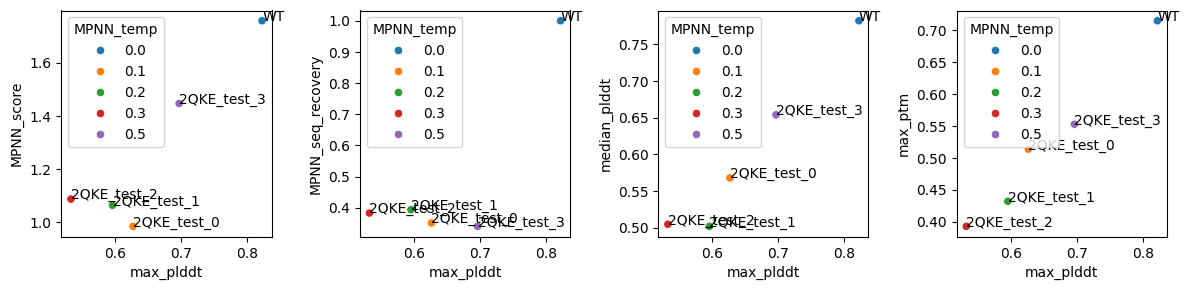

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
sns.scatterplot(x='max_plddt',y='MPNN_score',data=final_outputs,hue='MPNN_temp',palette='tab10')

for _, row in final_outputs.iterrows():
  plt.text(row['max_plddt'],row['MPNN_score'], row['design'])

plt.subplot(1,4,2)
sns.scatterplot(x='max_plddt',y='MPNN_seq_recovery',data=final_outputs,hue='MPNN_temp',palette='tab10')

for _, row in final_outputs.iterrows():
  plt.text(row['max_plddt'],row['MPNN_seq_recovery'], row['design'])

plt.subplot(1,4,3)

sns.scatterplot(x='max_plddt',y='median_plddt',data=final_outputs,hue='MPNN_temp',palette='tab10')

for _, row in final_outputs.iterrows():
  plt.text(row['max_plddt'],row['median_plddt'], row['design'])

plt.subplot(1,4,4)

sns.scatterplot(x='max_plddt',y='max_ptm',data=final_outputs,hue='MPNN_temp',palette='tab10')

for _, row in final_outputs.iterrows():
  plt.text(row['max_plddt'],row['max_ptm'], row['design'])

plt.tight_layout()